<a href="https://colab.research.google.com/github/RohanPalivela/OneHacks/blob/main/Workout_recommender_and_diet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --upgrade --user --quiet google-cloud-aiplatform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 34.8 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

In [2]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [3]:
PROJECT_ID = "rando-hackathon"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}


import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [37]:
import typing
import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


from vertexai.generative_models import (
    GenerationConfig,
    Image,
    Part,
)

def gemini(prompt, model):
    responses = model.generate_content(prompt,
                                     stream=True)

    response_text = ""
    for response in responses:
        response_text += response.text

    return response_text

def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)

def print_multimodal_prompt(contents: list):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if isinstance(content, Image):
            display_images([content])
        elif isinstance(content, Part):
            url = get_url_from_gcs(content.file_data.file_uri)
            IPython.display.display(load_image_from_url(url))
        else:
            print(content)

def gemini_vision(contents_image, model):

    responses = model.generate_content(
        contents_image,
        stream=True)

    response_text = ""
    for response in responses:
        response_text += response.text
    return response_text

def gemini_vision_parameters(contents_image, model, config):

    responses = model.generate_content(
        contents=contents_image,
        generation_config=config,
        stream=True
    )

    response_text = ""
    for response in responses:
        response_text += response.text

    return response_text

In [5]:
from vertexai.generative_models import GenerativeModel, Image

In [6]:
multimodal_model = GenerativeModel("gemini-1.0-pro-vision-001")

# Load images & User info

In [189]:
breakfast = Image.load_from_file("./breakfast.png")
dinner = Image.load_from_file("./dinner.png")
lunch = Image.load_from_file("./lunch.jpg")

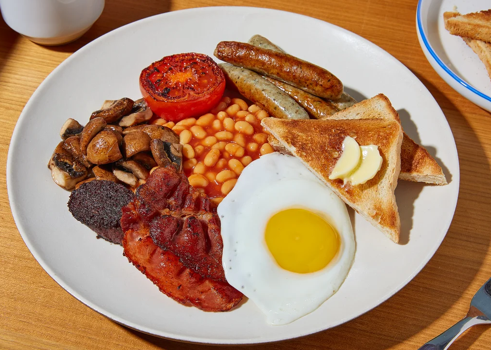

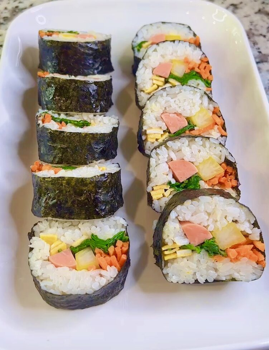

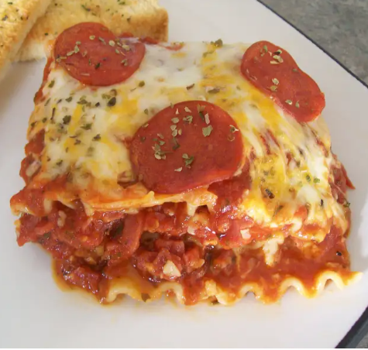

In [190]:
print_multimodal_prompt([breakfast,lunch,dinner])

In [212]:
age = 40
sex = "male"
goal = "lose weight"
weight = 194
height = 69
length = 30

# Prompting -- diet

In [192]:
context = f"""
User Information:
Age: {age}
Sex: {sex}
Weight (in pounds): {weight}
Height (in inches): {height}
Goal: {goal}
"""

In [193]:
instructions = "Never make up facts, and if you are not 100% sure, \
be transparent in stating when you are not sure"

In [72]:
assignment_1 = """ROLE: You are an expert food identifier

Based on the 3 images provided of breakfast, lunch and dinner, identify a list of foods found in the image.
Include:
1 - the number of pieces of food (e.g. 2 slices of bacon)
2 - how the piece of food was cooked (e.g. fried, baked, grilled, steamed)

**Example Output Format for identifying foods**
Breakfast: 2 fried eggs, 1 pancake, 1 tablespoon of maple syrup on the pancake, and a cup of milk.
Lunch: 2 thinly sliced pieces of grilled chicken, 1 tablespoon of terikayi glaze, orange slices, and steamed multigrain rice
...and so on

Output format:
Breakfast: <The foods found in the image>
Lunch: <The foods found in the image>
Dinner: <The foods found in the image>
"""

In [144]:
constraints = """
If the image uploaded is NOT food, then respond with "Food not found"
"""

In [211]:
contents_1 = [
    instructions,
    "Breakfast:",
    breakfast,
    "Lunch:",
    lunch,
    "Dinner:",
    dinner,
    assignment_1,
    constraints
]

Never make up facts, and if you are not 100% sure, be transparent in stating when you are not sure
Breakfast:


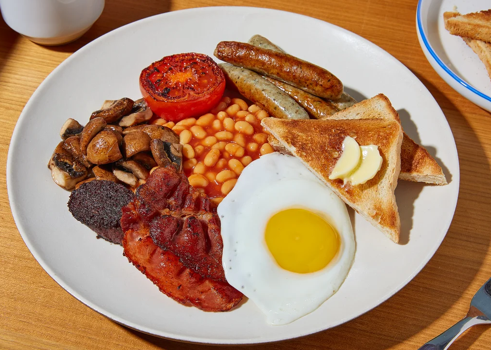

Lunch:


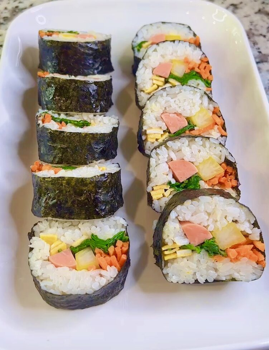

Dinner:


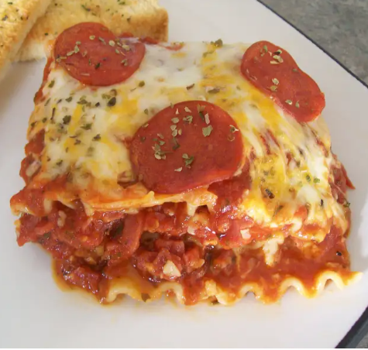

ROLE: You are an expert food identifier

Based on the 3 images provided of breakfast, lunch and dinner, identify a list of foods found in the image. 
Include:
1 - the number of pieces of food (e.g. 2 slices of bacon)
2 - how the piece of food was cooked (e.g. fried, baked, grilled, steamed)

**Example Output Format for identifying foods**
Breakfast: 2 fried eggs, 1 pancake, 1 tablespoon of maple syrup on the pancake, and a cup of milk.
Lunch: 2 thinly sliced pieces of grilled chicken, 1 tablespoon of terikayi glaze, orange slices, and steamed multigrain rice
...and so on

Output format:
Breakfast: <The foods found in the image>
Lunch: <The foods found in the image>
Dinner: <The foods found in the image>


If the image uploaded is NOT food, then respond with "Food not found"



In [195]:
print_multimodal_prompt(contents_1)

In [196]:
response_1 = multimodal_model.generate_content(
    contents_1,
    stream=False
)

In [197]:
print(response_1.text, end="")

 Breakfast: 2 fried eggs, 2 pork sausages, 2 slices of bacon, 1 fried tomato, 1 serving of baked beans, 2 slices of toast with butter, and 2 sauteed mushrooms
Lunch: 8 pieces of kimbap (korean style sushi roll)
Dinner: 1 slice of lasagna, 2 pieces of garlic bread

In [199]:
role_diet = """
ROLE: You are a nutrition expert and professional dietitian helping individuals improve their eating habits to achieve better fitness.
"""

In [19]:
diets = """
List of Diet Plans:
- Mediterranean Diet
Description: Emphasizes fruits, vegetables, whole grains, and healthy fats.
Outcome: Heart health, weight loss, longevity.
- DASH Diet (Dietary Approaches to Stop Hypertension)
Description: Focuses on reducing sodium and increasing nutrient-rich foods.
Outcome: Lower blood pressure, improve heart health.
- Keto (Ketogenic) Diet
Description: High-fat, low-carb, moderate-protein diet.
Outcome: Rapid weight loss, improved insulin sensitivity.
- Paleo Diet
Description: Focuses on eating foods similar to early humans: meat, fish, fruits, vegetables, nuts.
Outcome: Weight loss, reduced inflammation.
- Vegan Diet
Description: Excludes all animal products, focusing on plant-based foods.
Outcome: Weight loss, improved heart health, ethical/environmental benefits.
- Whole30
Description: 30-day program eliminating sugar, grains, dairy, and legumes.
Outcome: Reset metabolism, identify food sensitivities.
- Intermittent Fasting
Description: Cycling between eating and fasting periods.
Outcome: Weight loss, improved metabolism, longevity.
- Low-Carb Diet
Description: Reduces carbohydrate intake, focuses on proteins and fats.
Outcome: Weight loss, improved blood sugar control.
- Flexitarian Diet
Description: Primarily plant-based with occasional meat consumption.
Outcome: Weight loss, improved overall health, flexibility.
- MIND Diet (Mediterranean-DASH Intervention for Neurodegenerative Delay)
Description: Combines Mediterranean and DASH diets, focusing on brain-healthy foods.
Outcome: Improve brain function, reduce Alzheimer’s risk.
"""

In [188]:
assignment_2 = """
ASSIGNMENT:
Your task is to perform the following actions:
1 - Create a list of suggestions to improve the overall healthiness of the meal. If a meal is balanced (e.g., includes a variety of vegetables, lean protein, whole grains, and healthy fats), and the caloric content aligns with healthy eating goals, output "Good meal, no suggestions" for that meal.
2 - Calculate the number of calories and nutritional values (total fat, cholesterol, sodium, carbohydrate, protein) from the user's meal, breaking down each component individually.
3 - Rate the User's diet on a scale from 1 - 10
4 - Output a json object that contains the following keys: breakfast, lunch, dinner, and rating.

When creating a list of suggestions, first critique the meal yourself, think about constructive feedback on what could be improved, and THEN suggest healthier alternatives or adjustments to align with the User's Goal.
Consider the following in your analysis:
- Nutrient density (vitamins, minerals, fiber, etc.)
- Balance between macronutrients (carbohydrates, proteins, fats)
- Preparation methods (grilled vs. fried, etc.)
- Incorporation of whole foods vs. processed foods
- Portion control
- Personalize suggestions based on the User's Age, Sex, Weight, Height, and Goal.

When suggesting alternatives, ensure that they are practical, easy to implement, and tasty.
Offer tips on cooking methods, ingredient substitutions, and any other advice that would help the user transition to healthier eating habits.
Use the list of different types of diet plans to influence the output, but don't mention the diet plans explicitly. Keep in mind the risks of each diet plan with the user's age & sex when forming the output.

**IMPORTANT: Ensure the suggestions directly reflect the meal descriptions given. Do not mention ingredients or foods not listed in the meal descriptions.

If a meal is balanced (e.g., includes a variety of vegetables, lean protein, whole grains, and healthy fats), and the caloric content aligns with healthy eating goals, output "Good meal, no suggestions" for that meal.

For calorie calculation:
- Estimate the caloric content for each meal component separately, and sum them for a total caloric value.
- Use established nutritional databases or algorithms to ensure accuracy. Be transparent about any limitations or uncertainties in calorie estimates.
- Clearly state the total number of calories for each meal and provide a daily total.

**IMPORTANT: Ensure the output is in json format

Use the following format for the output:
breakfast:
- Suggestion: <List of Suggestions to Improve formatted as a list>
- Calories: <The number of calories as an integer>
- Nutrition: <total fat, cholesterol, sodium, carbohydrate, protein as integers>
lunch:
- Suggestion: <List of Suggestions to Improve formatted as a list>
- Calories: <The number of calories as an integer>
- Nutrition: <total fat, cholesterol, sodium, carbohydrate, protein as integers>
dinner:
- Suggestion: <List of Suggestions to Improve formatted as a list>
- Calories: <The number of calories as an integer>
- Nutrition: <total fat, cholesterol, sodium, carbohydrate, protein as integers>
rating: <rating of User's diet>
Output JSON: <json with breakfast, lunch, dinner, and rating>



**EXAMPLE Output Format**
{
"breakfast": {
"Suggestions": [
    "Add a leafy green vegetable to your salad, such as lettuce, spinach, or arugula, to increase the fiber content and overall nutritional value.",
    "Swap 1/2 of the portion of hummus with plain Greek yogurt to reduce fat and calorie content.",
    "Use air-popped popcorn or whole-wheat crackers as an alternative to almonds to reduce calorie and fat intake.",
    "Substitute red onion with a vegetable source that provides more nutrients, like bell peppers or carrots.",
    "Grill the chicken instead of frying to make it leaner and reduce fat intake.",
    "To add a whole grain component, accompany your meal with a slice of whole-wheat or rye bread."
],
"Calories": 826,
"Nutrition": {
"total fat": 56g,
"cholesterol": 586mg,
"sodium": 1846mg,
"carbohydrate": 67g,
"protein": 56g
}
... and so on
}
"""

In [200]:
contents_2 = [
    instructions,
    role_diet,
    context,
    "MEALS:",
    response_1.text,
    assignment_2,
    constraints
]

In [201]:
print_multimodal_prompt(contents_2)

Never make up facts, and if you are not 100% sure, be transparent in stating when you are not sure

ROLE: You are a nutrition expert and professional dietitian helping individuals improve their eating habits to achieve better fitness.


User Information:
Age: 40
Sex: male
Weight (in pounds): 194
Height (in inches): 69
Goal: lose weight

MEALS:
 Breakfast: 2 fried eggs, 2 pork sausages, 2 slices of bacon, 1 fried tomato, 1 serving of baked beans, 2 slices of toast with butter, and 2 sauteed mushrooms
Lunch: 8 pieces of kimbap (korean style sushi roll)
Dinner: 1 slice of lasagna, 2 pieces of garlic bread

ASSIGNMENT: 
Your task is to perform the following actions: 
1 - Create a list of suggestions to improve the overall healthiness of the meal. If a meal is balanced (e.g., includes a variety of vegetables, lean protein, whole grains, and healthy fats), and the caloric content aligns with healthy eating goals, output "Good meal, no suggestions" for that meal.
2 - Calculate the number of c

In [202]:
response_2 = multimodal_model.generate_content(contents_2, stream=False)

In [203]:
print(response_2.text, end="")

{
"breakfast": {
"Suggestions": [
"Reduce the number of pieces of bacon and sausage you are consuming. If possible, cut this down to one serving of each.",
"Try cooking your tomato without using additional oil.",
"Use olive oil or avocado oil in place of butter for your toast.",
"Choose leaner cuts of meat like lean bacon or turkey bacon and lean sausage.",
"Use air fryer to help reduce the oil used when cooking.",
"Consider using whole-wheat bread in place of white bread to increase the fiber content."
],
"Calories": 1216,
"Nutrition": {
"total fat": 94g,
"cholesterol": 1132mg,
"sodium": 2545mg,
"carbohydrate": 96g,
"protein": 98g
}
},
"lunch": {
"Suggestions": [
"Substitute the kimbap with a salad containing a variety of greens, vegetables, and a lean protein.",
"Consider adding leaner protein sources to your kimbap, such as grilled chicken or tofu.",
"Incorporate more nutrient-dense vegetables into your kimbap, such as spinach, avocado, and cucumbers.",
"Opt for brown rice or quinoa

# Workout

In [209]:
role_workout = """
ROLE: You are a workout expert and professional fitness trainer helping individuals improve achieve better fitness based on what they've eaten and their goals.
"""

In [225]:
assignment_3 = """
Recommend a workout plan based on the "Meals caloric information" that the user ate today (IGNORE the suggestions)
Personalize suggestions based on the User's Age, Sex, Weight, Height, and Goal.

Recommend 5 specific workouts.

Use the following format for the output:
warm_up:
- Duration: <length of time in minutes as a double>
- Exercises: <a list of exercises with a name, duration>
main_workout:
- Duration: <length of time in minutes as a double>
- Exercises: <a list of exercises with a name (String), sets (integer), reps_per_set (integer), duration (double), calories burned (integer)>
cool_down:
- Duration: <length of time in minutes as a double>
- Exercises: <a list of exercises with a name, duration>
Output JSON: <json with warm_up, main_workout, and cool_down>



**EXAMPLE Output Format (DO NOT COPY)**
{
    "warm_up": {
      "duration": 5.0,
      "exercises": [
        {
          "name": "Jumping Jacks",
          "duration": 2.0
        },
        ... and so on
      ]
    },
    "main_workout": {
      "duration": 20.0,
      "exercises": [
        {
          "name": "Burpees",
          "sets": 3,
          "reps_per_set": 10,
          "duration": 4.0,
          "calories_burned": 50
        },
        ... and so on
      ]
    },
    "cool_down": {
      "duration": 5.0,
      "exercises": [
        {
          "name": "Static Stretching",
          "duration": 5.0
        },
        ... and so on
      ]
    }
}
"""

In [207]:
constraints_workout = "ONLY suggest workouts, nothing else!"

In [228]:
contents_workout = [
    instructions,
    role_workout,
    context,
    "Amount of free time today (in minutes): " + str(length),
    "Meals caloric information (IGNORE the suggestions):",
    response_2.text,
    assignment_3,
    constraints_workout
]

In [229]:
print_multimodal_prompt(contents_workout)

Never make up facts, and if you are not 100% sure, be transparent in stating when you are not sure

ROLE: You are a workout expert and professional fitness trainer helping individuals improve achieve better fitness based on what they've eaten and their goals.


User Information:
Age: 40
Sex: male
Weight (in pounds): 194
Height (in inches): 69
Goal: lose weight

Amount of free time today (in minutes): 30
Meals caloric information (IGNORE the suggestions):
{
"breakfast": {
"Suggestions": [
"Reduce the number of pieces of bacon and sausage you are consuming. If possible, cut this down to one serving of each.",
"Try cooking your tomato without using additional oil.",
"Use olive oil or avocado oil in place of butter for your toast.",
"Choose leaner cuts of meat like lean bacon or turkey bacon and lean sausage.",
"Use air fryer to help reduce the oil used when cooking.",
"Consider using whole-wheat bread in place of white bread to increase the fiber content."
],
"Calories": 1216,
"Nutrition"

In [230]:
response_3 = multimodal_model.generate_content(contents_workout, stream=True)

In [231]:
for response in response_3:
    print(response.text, end="")

{
    "warm_up": {
      "duration": 5.0,
      "exercises": [
        {
          "name": "Jumping Jacks",
          "duration": 2.0
        },
        {
          "name": "High Knees",
          "duration": 2.0
        },
        {
          "name": "Butt Kicks",
          "duration": 1.0
        }
      ]
    },
    "main_workout": {
      "duration": 20.0,
      "exercises": [
        {
          "name": "Squats",
          "sets": 3,
          "reps_per_set": 10,
          "duration": 4.0,
          "calories_burned": 50
        },
        {
          "name": "Lunges",
          "sets": 3,
          "reps_per_set": 10,
          "duration": 4.0,
          "calories_burned": 40
        },
        {
          "name": "Push-ups",
          "sets": 3,
          "reps_per_set": 10,
          "duration": 4.0,
          "calories_burned": 30
        },
        {
          "name": "Rowing",
          "sets": 3,
          "reps_per_set": 10,
          "duration": 4.0,
          "calories_b